In [1]:
import tensorflow as tf
print(tf.__version__)

import tensorflow_probability as tfp
print('tfp version', tfp.__version__)
tfd = tfp.distributions
tfb = tfp.bijectors

import healpy as hp

import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
import jax

import jaxlib

import numpy as np

print('jax version: ', jax.__version__)
print('jaxlib version: ', jaxlib.__version__)


# tensorflow-prob VANILLA
tfd = tfp.distributions
tfb = tfp.bijectors

# # tensorflow-prob-JAX
import tensorflow_probability.substrates.jax as tfpj

tfdj = tfpj.distributions
tfbj = tfpj.bijectors

# matplotlib stuff
import matplotlib.pyplot as plt

# flax import
import flax.linen as nn
import optax

# for imnn
import imnn
import imnn.lfi
from imnn.utils import value_and_jacrev, value_and_jacfwd


# powerbox
import powerbox_jax as pbj
import powerbox as pbox

rng = random.PRNGKey(2)

2.7.0
tfp version 0.13.0
jax version:  0.2.21
jaxlib version:  0.1.69


In [2]:
# first visualize data
datapath = '/data80/makinen/hirax_sims/draco_output/'

In [3]:
import h5py

In [4]:
f_fg = h5py.File(datapath + 'mlmap_galaxy_0.h5', 'r')
f_cosmo = h5py.File(datapath + 'mlmap_21cm_0.h5', 'r')

In [5]:
def gen_rearr(nside):
    # recursive funtion for finding the right 
    # ordering for the nested pixels 
    if (nside==1):
        return np.array([0,1,2,3])
    else:
        smaller = np.reshape(gen_rearr(nside-1),(2**(nside-1),2**(nside-1)))
        npixsmaller = 2**(2*(nside-1))
        top = np.concatenate((smaller,smaller+npixsmaller),axis=1)
        bot = np.concatenate((smaller+2*npixsmaller,smaller+3*npixsmaller),axis=1)
        whole = np.concatenate((top,bot))
        return whole.flatten()

In [6]:
# "GLOBAL" parameters
N_NU_OUT = 64

#(NU_L,NU_H) = (1,N_NU_OUT*NU_AVG)
N_SKIP = 1
N_FREQS = 690
N_FREQ_BINS = 4
#assert(((NU_H-NU_L + 1)%NU_AVG) ==0)
MAP_NSIDE = 256
SIM_NSIDE = MAP_NSIDE
WINDOW_NSIDE = 4
NUM_SIMS = 1
# resolution of the outgoing window
NPIX_WINDOW = (MAP_NSIDE/WINDOW_NSIDE)**2
# actual side length of window
WINDOW_LENGTH = int(np.sqrt(NPIX_WINDOW))

# rearrange indices
rearr = gen_rearr(int(np.log2(MAP_NSIDE/WINDOW_NSIDE)))
nwinds = int(hp.nside2npix(WINDOW_NSIDE))

In [7]:
fg = np.array(f_fg['map'])[0:N_NU_OUT, 0, :].T     # put freqs last
cosmo = np.array(f_cosmo['map'])[0:N_NU_OUT, 0, :].T

In [8]:
# add fg and cosmo together
obs = fg + cosmo

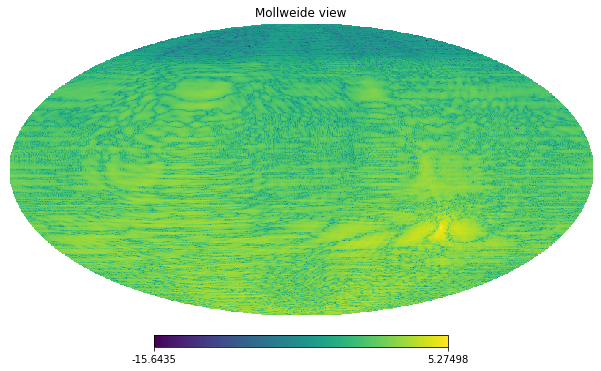

In [9]:
hp.mollview(np.log(np.abs(fg.T[45])), nest=False)

In [10]:
x_out = np.zeros((NUM_SIMS*nwinds,SIM_NSIDE//WINDOW_NSIDE,SIM_NSIDE//WINDOW_NSIDE,N_NU_OUT))
#pca_outs = [x_out.copy() for i in range(len(COMPONENTS))]

In [11]:
# get the array indices in the RING formulation
inds = np.arange(hp.nside2npix(MAP_NSIDE))
# transfer these to what they would be in the NESTED formulation  
inds_nest = hp.ring2nest(MAP_NSIDE,inds)

In [12]:
# first some additional packages that we'll need
import healpy as hp
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# ----------------------------------------------------------------------------
def gen_rearr(nside):
    # recursive funtion for finding the right 
    # ordering for the nested pixels 
    if (nside==1):
        return np.array([0,1,2,3])
    else:
        smaller = np.reshape(gen_rearr(nside-1),(2**(nside-1),2**(nside-1)))
        npixsmaller = 2**(2*(nside-1))
        top = np.concatenate((smaller,smaller+npixsmaller),axis=1)
        bot = np.concatenate((smaller+2*npixsmaller,smaller+3*npixsmaller),axis=1)
        whole = np.concatenate((top,bot))
        return whole.flatten()

# ----------------------------------------------------------------------------

# for this demo, we'll pull in a pre-computed index to get our data
# from the shape (192, N_x, N_y, N_nu) to the HEALPix ring
# data format (192*64*64, 64)


def map_to_tiles(input_map, index_array, n_nu=None, n_nu_avg=3, n_nu_out=64, output_shape=None):
    # "GLOBAL" parameters ----------------------------------------------------
    MAP_NSIDE = 256
    SIM_NSIDE = MAP_NSIDE
    WINDOW_NSIDE = 4
    NUM_SIMS = 1
    # resolution of the outgoing window
    NPIX_WINDOW = (MAP_NSIDE/WINDOW_NSIDE)**2
    # actual side length of window
    WINDOW_LENGTH = int(np.sqrt(NPIX_WINDOW))
    # ------------------------------------------------------------------------

    # rearrange indices
    rearr = gen_rearr(int(np.log2(MAP_NSIDE/WINDOW_NSIDE)))
    nwinds = int(hp.nside2npix(WINDOW_NSIDE))
    
    
    # allocate the output array
    if output_shape is None:
        map_out = np.zeros(input_map.shape)
    else:
        map_out = np.zeros(output_shape)
    
    # flatten input map into full-sky maps stacked in frequency
    #input_map = input_map.reshape((-1, N_NU_OUT)) #[index_array]


    # get the array indices in the RING formulation
    inds = np.arange(hp.nside2npix(MAP_NSIDE))
    # transfer these to what they would be in the NESTED formulation  
    inds_nest = hp.ring2nest(MAP_NSIDE,inds) # hp.nest2ring(MAP_NSIDE,inds)


    for PIX_SELEC in np.arange(hp.nside2npix(WINDOW_NSIDE)):
        # get the indices of the pixels which actually are in the larger pixel
        inds_in = np.where((inds_nest//NPIX_WINDOW)==PIX_SELEC)
        to_rearr_inds = inds_nest[inds_in] - PIX_SELEC*NPIX_WINDOW
        to_rearr = input_map[inds_in]
        to_rearr = (to_rearr[np.argsort(to_rearr_inds)])[rearr]
        to_rearr = np.reshape(to_rearr,(WINDOW_LENGTH,WINDOW_LENGTH,n_nu_out))
        ind = (0)*nwinds + PIX_SELEC
        map_out[ind] = to_rearr
                  
    return map_out
    
    
  
    

def pca_subtraction(input_map, n_comp, index_array, n_nu=None, 
                    nu_arr=None, nu_start=0, n_nu_out=64, n_nu_avg=3, output_shape=None):
  
    # "GLOBAL" parameters ----------------------------------------------------
    MAP_NSIDE = 256
    SIM_NSIDE = MAP_NSIDE
    WINDOW_NSIDE = 4
    NUM_SIMS = 1
    # resolution of the outgoing window
    NPIX_WINDOW = (MAP_NSIDE/WINDOW_NSIDE)**2
    # actual side length of window
    WINDOW_LENGTH = int(np.sqrt(NPIX_WINDOW))
    # ------------------------------------------------------------------------

    # rearrange indices
    rearr = gen_rearr(int(np.log2(MAP_NSIDE/WINDOW_NSIDE)))
    nwinds = int(hp.nside2npix(WINDOW_NSIDE))
  
    if nu_arr is not None:
        print('working in frequency range ', nu_arr[nu_start], '--', 
                                nu_arr[nu_start + (n_nu*n_nu_avg)-1], 
                ' MHz')
      
    # initialize the PCA algorithm
    pca = PCA()
    
    # allocate the output array
    if output_shape is None:
        pca_reduced_out = np.zeros(input_map.shape)
    else:
        pca_reduced_out = np.zeros(output_shape)
    
    # flatten input map into full-sky maps stacked in frequency
    #input_map = input_map.reshape((-1, N_NU_OUT))[index_array]
  
    # do PCA removal of n_comp components
    pca.fit(input_map)
    obs_pca = pca.transform(input_map)
    ind_arr = np.reshape(np.arange(np.prod(np.array(obs_pca.shape))),obs_pca.shape)

  
    mask = np.ones(obs_pca.shape)
    for i in range(n_comp, obs_pca.shape[1]):
        mask[ind_arr%obs_pca.shape[1]==i] = 0
        
    obs_pca = obs_pca*mask
    obs_pca_red = pca.inverse_transform(obs_pca)
    print("Now I'm doing the minimum subtraction...")
    print("...removing the first %d principal components"%(n_comp))
    obs_pca_red = input_map - obs_pca_red

    # get the array indices in the RING formulation
    inds = np.arange(hp.nside2npix(MAP_NSIDE))
    # transfer these to what they would be in the NESTED formulation  
    inds_nest = hp.ring2nest(MAP_NSIDE,inds) # hp.nest2ring(MAP_NSIDE,inds)


    for PIX_SELEC in np.arange(hp.nside2npix(WINDOW_NSIDE)):
        # get the indices of the pixels which actually are in the larger pixel
        inds_in = np.where((inds_nest//NPIX_WINDOW)==PIX_SELEC)
        to_rearr_inds = inds_nest[inds_in] - PIX_SELEC*NPIX_WINDOW
        to_rearr = obs_pca_red[inds_in]
        to_rearr = (to_rearr[np.argsort(to_rearr_inds)])[rearr]
        to_rearr = np.reshape(to_rearr,(WINDOW_LENGTH,WINDOW_LENGTH,n_nu_out))
        ind = (0)*nwinds + PIX_SELEC
        pca_reduced_out[ind] = to_rearr
                  
    return pca_reduced_out

In [13]:
index_arr = np.load('rearr_nside4.npy', allow_pickle=False)

In [14]:
cosmo.shape

(786432, 64)

In [15]:
cosmo_tiles = map_to_tiles(cosmo, index_arr, n_nu=N_NU_OUT, n_nu_avg=1, output_shape=(192, 64, 64, N_NU_OUT))

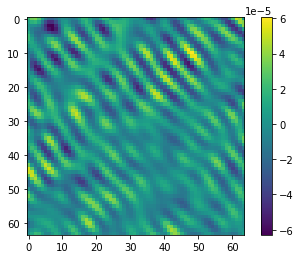

In [16]:
plt.imshow(cosmo_tiles[120, :, :, 32])
plt.colorbar()

In [17]:
%%time

obs_map = obs #.reshape((192, 64, 64, N_NU_OUT))

n_side = 4   # data arrangement parameter
n_voxels = hp.nside2npix(4) 
print('we have %d voxels per sky simulation'%(n_voxels))

splt = 1 #obs_map.shape[0]//n_voxels
print("we\'re working with %d sky simulations"%(splt))
pca3 = []

for i,sky in enumerate(np.split(obs_map, splt, axis=0)):
# do the PCA subtraction for each map separately
    print('starting PCA subtraction for sky %d'%(i+1))
    pca3.append(pca_subtraction(sky, 6, index_arr, n_nu=N_NU_OUT, 
                    nu_arr=None, nu_start=0, n_nu_out=N_NU_OUT, n_nu_avg=1, output_shape=(192, 64, 64, N_NU_OUT)))
    
pca3 = np.concatenate(pca3, axis=0)
print('I put the PCA-3 subtraction put back into this shape : ', pca3.shape)

we have 192 voxels per sky simulation
we're working with 1 sky simulations
starting PCA subtraction for sky 1
Now I'm doing the minimum subtraction...
...removing the first 6 principal components
I put the PCA-3 subtraction put back into this shape :  (192, 64, 64, 64)
CPU times: user 1min 18s, sys: 18.1 s, total: 1min 36s
Wall time: 36.8 s


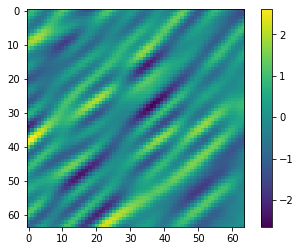

In [18]:
plt.imshow(pca3[150, :, :, 32])
plt.colorbar()

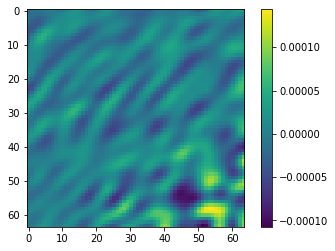

In [19]:
plt.imshow(cosmo_tiles[150, :, :, 2])
plt.colorbar()

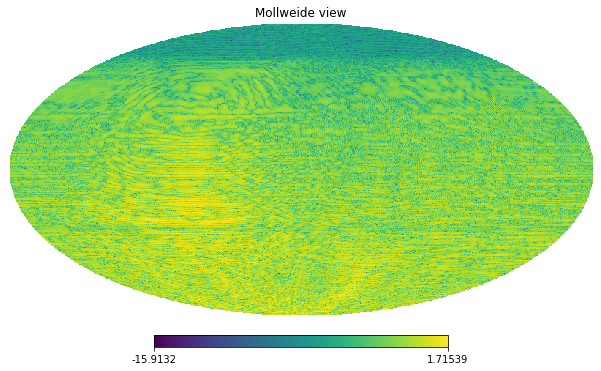

In [20]:
hp.mollview(np.log(np.abs(pca3[:, :, :, 32].flatten()[index_arr])), nest=False)

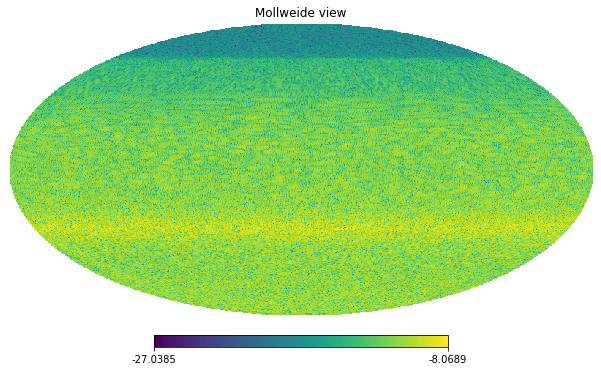

In [21]:
hp.mollview(np.log(np.abs(cosmo_tiles[:, :, :, 32].flatten()[index_arr])), nest=False)

In [22]:
#@jax.jit
def get_mean_and_covariance(x):
    x = x.reshape((x.shape[0], -1))
    μ = x.mean(axis=0)
    normalised = x - μ
    Σ = jnp.tensordot(
            jnp.transpose(normalised),
            normalised,
            axes=1)
    D = 1. / jnp.sqrt(jnp.einsum("ii->i", Σ))
    Corr = jnp.einsum("i,ij,j->ij", D, Σ, D)
    return μ, Σ, Corr


#@jax.jit
def get_eigenvalues_and_transformed_input(x, μ, Σ):
    eigval, eigvec = jnp.linalg.eigh(Σ)
    x_prime = jnp.transpose(
        jnp.tensordot(
            jnp.transpose(eigvec), 
            jnp.transpose(x.reshape((x.shape[0], -1)) - μ),
            axes=1))
    return eigval, x_prime

labels = np.random.normal(size=(200,200, 1))#jnp.array(cosmo)

label_μ, label_Σ, label_Corr = get_mean_and_covariance(labels)
label_eigenvalue, transformed_labels = get_eigenvalues_and_transformed_input(labels, label_μ, label_Σ)

In [26]:
obs_map.shape

(786432, 64)

In [31]:
#@jax.jit
def get_mean_and_covariance(x):
    x = x.reshape((x.shape[0], -1))
    μ = x.mean(axis=0)
    normalised = x - μ
    Σ = jnp.tensordot(
            jnp.transpose(normalised),
            normalised,
            axes=1)
    D = 1. / jnp.sqrt(jnp.einsum("ii->i", Σ))
    Corr = jnp.einsum("i,ij,j->ij", D, Σ, D)
    return μ, Σ, Corr


def fori_loop(lower, upper, body_fun, init_val):
    val = init_val
    for i in range(lower, upper):
        val = body_fun(i, val)
    return val



#@jax.jit
def get_eigenvalues_and_subtracted_input(x, μ, Σ, n_comp, ind_array):
    eigval, eigvec = jnp.linalg.eigh(Σ)
    
    print(x.shape)
    
    # forwards transformation: Λ^T \dot X
    x_prime = jnp.transpose(
        jnp.tensordot(
            jnp.transpose(eigvec), 
            jnp.transpose(x.reshape((x.shape[0], -1)) - μ),
            axes=1))  # this is the transformed input
    
    
    print('xprime', x_prime.shape)
    
    mask = np.ones(x_prime.shape)
    print('mask shape', mask.shape)
    
    def mask_components(i, mask):
        mask = jax.ops.index_update(
                    mask,
                    ind_array%x_prime.shape[1]==i,
                    0
                    )
        return mask
    
    

    # mask = jax.lax.fori_loop(lower=n_comp,
    #                          upper=x_prime.shape[1],
    #                          body_fun=mask_components,
    #                          init_val=mask)
                             
    
    for i in range(n_comp, x_prime.shape[1]):
        mask = jax.ops.index_update(
                    mask,
                    ind_array%x_prime.shape[1]==i,
                    0
        )
        #mask[ind_array%x_prime.shape[1]==i] = 0

    x_prime = x_prime*mask
    
    print('xprime', x_prime.shape)
    print('eigvec', eigvec.shape)
    
    # backwards transformation: Λ \dot X
    x_prime = jnp.transpose(
        jnp.tensordot(
            eigvec, 
            jnp.transpose(x_prime.reshape(x_prime.shape[0], -1)),
            axes=1)) + μ  # this is the transformed input
    
    
    #obs_pca_red = pca.inverse_transform(obs_pca)
    #print("Now I'm doing the minimum subtraction...")
    #print("...removing the first %d principal components"%(n_comp))
    x_prime = x - x_prime
    
    print('xprime', x_prime.shape)
    
    return eigval, x_prime

labels = np.random.normal(size=(120, 32)) + np.random.normal(size=(120, 32), scale=2.5) + np.random.normal(size=(120, 32), scale=13)

labels = jnp.array(labels)

inds = jnp.reshape(jnp.arange(jnp.prod(jnp.array(labels.shape))),labels.shape)


label_μ, label_Σ, label_Corr = get_mean_and_covariance(labels)
label_eigenvalue, transformed_labels = get_eigenvalues_and_subtracted_input(labels, label_μ, label_Σ, n_comp=1, ind_array=inds)


(120, 32)
xprime (120, 32)
mask shape (120, 32)
xprime (120, 32)
eigvec (32, 32)
xprime (120, 32)


In [32]:
inds.shape

(120, 32)

In [33]:
label_eigenvalue.shape

(32,)

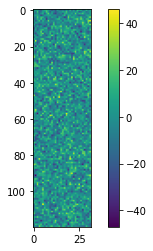

In [34]:
plt.imshow(labels)
plt.colorbar()

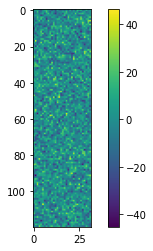

In [35]:
plt.imshow(transformed_labels)
plt.colorbar()